<a href="https://colab.research.google.com/github/RAKESH15122004/Apple-Leaf-Disease-Classifier/blob/main/Copy_of_Travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, pickle, time
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# --- FILE PATHS (adjust these if your CSVs are located elsewhere) ---
paths = {
    "reviews": "Final_Updated_Expanded_Reviews.csv",
    "history": "Final_Updated_Expanded_UserHistory.csv",
    "users": "Final_Updated_Expanded_Users.csv"
}

# --- LOAD DATA (with graceful fallback to synthetic data) ---
def safe_read_csv(path, fallback_rows=200):
    if os.path.exists(path):
        print(f"✅ Loaded file: {path}")
        return pd.read_csv(path)
    else:
        print(f"⚠️ File not found: {path}. Generating synthetic fallback data.")
        # create a small synthetic DataFrame with expected columns
        np.random.seed(42)
        df = pd.DataFrame({
            "UserID": np.arange(fallback_rows),
            "DestinationID": np.random.choice(["Paris", "Rome", "London", "Tokyo", "NewYork"], fallback_rows),
            "Rating": np.random.randint(1, 6, fallback_rows),
            "ReviewText": np.random.choice([
                "Amazing trip!", "Very bad experience", "Loved the food and sights",
                "Hotel was clean", "Would not recommend", "Best vacation ever"
            ], fallback_rows),
            "Preferences": np.random.choice(["Adventure", "Relaxation", "Cultural", "Family"], fallback_rows),
            "Gender": np.random.choice(["Male", "Female"], fallback_rows)
        })
        return df

reviews = safe_read_csv(paths["reviews"])
history = safe_read_csv(paths["history"])
users = safe_read_csv(paths["users"])

# --- NORMALIZE COLUMN NAMES ---
def find_col(df, candidates):
    cols_map = {c.lower().replace(" ", "").replace("_",""): c for c in df.columns}
    for cand in candidates:
        key = cand.lower().replace(" ", "").replace("_","")
        if key in cols_map:
            return cols_map[key]
    return None

for df in [reviews, history, users]:
    uc = find_col(df, ["UserID","userid","user_id","user id","user"])
    dc = find_col(df, ["DestinationID","destinationid","dest_id","destid","destination"])
    rename = {}
    if uc: rename[uc] = "UserID"
    if dc: rename[dc] = "DestinationID"
    if rename:
        df.rename(columns=rename, inplace=True)

# --- MERGE DATASETS SAFELY ---
main = reviews.copy()
if "UserID" in users.columns:
    main = main.merge(users, on="UserID", how="left", suffixes=("","_user"))
if "UserID" in history.columns and "ExperienceRating" in history.columns:
    hist_agg = history.groupby("UserID").agg({"ExperienceRating":"mean"}).reset_index().rename(columns={"ExperienceRating":"AvgExperienceRating"})
    main = main.merge(hist_agg, on="UserID", how="left")

# --- FEATURE PREP ---
main["ReviewText"] = main.get("ReviewText", "").astype(str)
main["ReviewText_len"] = main["ReviewText"].apply(len)

numeric_candidates = ["Rating","ReviewText_len","AvgExperienceRating","NumberOfAdults","NumberOfChildren"]
numeric_cols = [c for c in numeric_candidates if c in main.columns]
cat_candidates = ["Preferences","Gender"]
cat_cols = [c for c in cat_candidates if c in main.columns]

# --- TARGET VARIABLE ---
y = main.get("DestinationID", pd.Series(["Unknown"] * len(main))).astype(str)
max_classes = 20
if y.nunique() > max_classes:
    top_labels = y.value_counts().index[:max_classes]
    y = y.apply(lambda x: x if x in top_labels else "Other")

vc = y.value_counts()
rare = vc[vc < 2].index.tolist()
if rare:
    y = y.apply(lambda x: x if x not in rare else "Other")

# --- FILL MISSING ---
X = main[numeric_cols + cat_cols + ["ReviewText"]].copy()
for c in numeric_cols:
    X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    X[c] = X[c].fillna("missing")

# --- SPLIT DATA ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# --- TF-IDF ---
tfidf = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train["ReviewText"])
X_test_tfidf = tfidf.transform(X_test["ReviewText"])

# --- ONE-HOT ENCODING ---
if cat_cols:
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(X_train[cat_cols])
    X_train_cat = ohe.transform(X_train[cat_cols])
    X_test_cat = ohe.transform(X_test[cat_cols])
else:
    X_train_cat = csr_matrix(np.empty((len(X_train),0)))
    X_test_cat = csr_matrix(np.empty((len(X_test),0)))

# --- NUMERIC ---
if numeric_cols:
    X_train_num = X_train[numeric_cols].values
    X_test_num = X_test[numeric_cols].values
else:
    X_train_num = np.empty((len(X_train),0))
    X_test_num = np.empty((len(X_test),0))

# --- STACK FEATURES ---
X_train_full = hstack([csr_matrix(X_train_num), X_train_cat, X_train_tfidf]).tocsr()
X_test_full = hstack([csr_matrix(X_test_num), X_test_cat, X_test_tfidf]).tocsr()

# --- SCALE FOR KNN ---
if X_train_num.shape[1] > 0:
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_train_full[:, :X_train_num.shape[1]])
    X_train_num_scaled = scaler.transform(X_train_full[:, :X_train_num.shape[1]])
    X_test_num_scaled = scaler.transform(X_test_full[:, :X_train_num.shape[1]])
    X_train_knn = hstack([X_train_num_scaled, X_train_full[:, X_train_num.shape[1]:]]).tocsr()
    X_test_knn = hstack([X_test_num_scaled, X_test_full[:, X_train_num.shape[1]:]]).tocsr() # Ensure X_test_knn is defined
else:
    X_train_knn = X_train_full
    X_test_knn = X_test_full # Ensure X_test_knn is defined

# --- SAVE PREPROCESSORS ---
os.makedirs("/mnt/data", exist_ok=True)
with open("/mnt/data/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("/mnt/data/onehot_encoder.pkl", "wb") as f:
    pickle.dump(ohe, f)
if 'scaler' in locals(): # Only save if scaler was created
    with open("/mnt/data/num_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
with open("/mnt/data/feature_cols.pkl", "wb") as f:
    pickle.dump((numeric_cols, cat_cols), f)
print("\n✅ Saved preprocessors: /mnt/data/tfidf_vectorizer.pkl, /mnt/data/onehot_encoder.pkl, /mnt/data/num_scaler.pkl (if exists), /mnt/data/feature_cols.pkl")


# --- LIMITED GRID SEARCH (FAST) ---
print("\n🚀 Running fast GridSearchCV for KNN and RF ...")

param_grid_knn = {"n_neighbors": [3,5,7]}
grid_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid_knn, cv=2, scoring="accuracy", n_jobs=-1)
start = time.time()
grid_knn.fit(X_train_knn, y_train)
print(f"KNN tuning done in {time.time()-start:.1f} sec | Best: {grid_knn.best_params_} | CV score: {grid_knn.best_score_:.3f}")

param_grid_rf = {"n_estimators":[100,200], "max_depth":[None,10], "min_samples_split":[2]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid_rf, cv=2, scoring="accuracy", n_jobs=-1)
start = time.time()
# Convert sparse to dense carefully for small fallback data
grid_rf.fit(X_train_full.toarray(), y_train)
print(f"RF tuning done in {time.time()-start:.1f} sec | Best: {grid_rf.best_params_} | CV score: {grid_rf.best_score_:.3f}")

# --- SAVE MODELS ---
os.makedirs("/mnt/data", exist_ok=True)
with open("/mnt/data/fast_best_knn.pkl","wb") as f:
    pickle.dump(grid_knn.best_estimator_, f)
with open("/mnt/data/fast_best_rf.pkl","wb") as f:
    pickle.dump(grid_rf.best_estimator_, f)
print("\n✅ Saved models: /mnt/data/fast_best_knn.pkl and /mnt/data/fast_best_rf.pkl")

⚠️ File not found: Final_Updated_Expanded_Reviews.csv. Generating synthetic fallback data.
⚠️ File not found: Final_Updated_Expanded_UserHistory.csv. Generating synthetic fallback data.
⚠️ File not found: Final_Updated_Expanded_Users.csv. Generating synthetic fallback data.

✅ Saved preprocessors: /mnt/data/tfidf_vectorizer.pkl, /mnt/data/onehot_encoder.pkl, /mnt/data/num_scaler.pkl (if exists), /mnt/data/feature_cols.pkl

🚀 Running fast GridSearchCV for KNN and RF ...
KNN tuning done in 5.3 sec | Best: {'n_neighbors': 3} | CV score: 0.260
RF tuning done in 5.7 sec | Best: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200} | CV score: 0.260

✅ Saved models: /mnt/data/fast_best_knn.pkl and /mnt/data/fast_best_rf.pkl


In [2]:
import os, pickle, time
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# --- FILE PATHS (adjust these if your CSVs are located elsewhere) ---
paths = {
    "reviews": "Final_Updated_Expanded_Reviews.csv",
    "history": "Final_Updated_Expanded_UserHistory.csv",
    "users": "Final_Updated_Expanded_Users.csv"
}

# --- LOAD DATA (with graceful fallback to synthetic data) ---
def safe_read_csv(path, fallback_rows=200):
    if os.path.exists(path):
        print(f"✅ Loaded file: {path}")
        return pd.read_csv(path)
    else:
        print(f"⚠️ File not found: {path}. Generating synthetic fallback data.")
        # create a small synthetic DataFrame with expected columns
        np.random.seed(42)
        df = pd.DataFrame({
            "UserID": np.arange(fallback_rows),
            "DestinationID": np.random.choice(["Paris", "Rome", "London", "Tokyo", "NewYork"], fallback_rows),
            "Rating": np.random.randint(1, 6, fallback_rows),
            "ReviewText": np.random.choice([
                "Amazing trip!", "Very bad experience", "Loved the food and sights",
                "Hotel was clean", "Would not recommend", "Best vacation ever"
            ], fallback_rows),
            "Preferences": np.random.choice(["Adventure", "Relaxation", "Cultural", "Family"], fallback_rows),
            "Gender": np.random.choice(["Male", "Female"], fallback_rows)
        })
        return df

reviews = safe_read_csv(paths["reviews"])
history = safe_read_csv(paths["history"])
users = safe_read_csv(paths["users"])

# --- NORMALIZE COLUMN NAMES ---
def find_col(df, candidates):
    cols_map = {c.lower().replace(" ", "").replace("_",""): c for c in df.columns}
    for cand in candidates:
        key = cand.lower().replace(" ", "").replace("_","")
        if key in cols_map:
            return cols_map[key]
    return None

for df in [reviews, history, users]:
    uc = find_col(df, ["UserID","userid","user_id","user id","user"])
    dc = find_col(df, ["DestinationID","destinationid","dest_id","destid","destination"])
    rename = {}
    if uc: rename[uc] = "UserID"
    if dc: rename[dc] = "DestinationID"
    if rename:
        df.rename(columns=rename, inplace=True)

# --- MERGE DATASETS SAFELY ---
main = reviews.copy()
if "UserID" in users.columns:
    main = main.merge(users, on="UserID", how="left", suffixes=("","_user"))
if "UserID" in history.columns and "ExperienceRating" in history.columns:
    hist_agg = history.groupby("UserID").agg({"ExperienceRating":"mean"}).reset_index().rename(columns={"ExperienceRating":"AvgExperienceRating"})
    main = main.merge(hist_agg, on="UserID", how="left")

# --- FEATURE PREP ---
main["ReviewText"] = main.get("ReviewText", "").astype(str)
main["ReviewText_len"] = main["ReviewText"].apply(len)

numeric_candidates = ["Rating","ReviewText_len","AvgExperienceRating","NumberOfAdults","NumberOfChildren"]
numeric_cols = [c for c in numeric_candidates if c in main.columns]
cat_candidates = ["Preferences","Gender"]
cat_cols = [c for c in cat_candidates if c in main.columns]

# --- TARGET VARIABLE ---
y = main.get("DestinationID", pd.Series(["Unknown"] * len(main))).astype(str)
max_classes = 20
if y.nunique() > max_classes:
    top_labels = y.value_counts().index[:max_classes]
    y = y.apply(lambda x: x if x in top_labels else "Other")

vc = y.value_counts()
rare = vc[vc < 2].index.tolist()
if rare:
    y = y.apply(lambda x: x if x not in rare else "Other")

# --- FILL MISSING ---
X = main[numeric_cols + cat_cols + ["ReviewText"]].copy()
for c in numeric_cols:
    X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    X[c] = X[c].fillna("missing")

# --- SPLIT DATA ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# --- TF-IDF ---
tfidf = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train["ReviewText"])
X_test_tfidf = tfidf.transform(X_test["ReviewText"])

# --- ONE-HOT ENCODING ---
if cat_cols:
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(X_train[cat_cols])
    X_train_cat = ohe.transform(X_train[cat_cols])
    X_test_cat = ohe.transform(X_test[cat_cols])
else:
    X_train_cat = csr_matrix(np.empty((len(X_train),0)))
    X_test_cat = csr_matrix(np.empty((len(X_test),0)))

# --- NUMERIC ---
if numeric_cols:
    X_train_num = X_train[numeric_cols].values
    X_test_num = X_test[numeric_cols].values
else:
    X_train_num = np.empty((len(X_train),0))
    X_test_num = np.empty((len(X_test),0))

# --- STACK FEATURES ---
X_train_full = hstack([csr_matrix(X_train_num), X_train_cat, X_train_tfidf]).tocsr()
X_test_full = hstack([csr_matrix(X_test_num), X_test_cat, X_test_tfidf]).tocsr()

# --- SCALE FOR KNN ---
if X_train_num.shape[1] > 0:
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_train_full[:, :X_train_num.shape[1]])
    X_train_num_scaled = scaler.transform(X_train_full[:, :X_train_num.shape[1]])
    X_test_num_scaled = scaler.transform(X_test_full[:, :X_train_num.shape[1]])
    X_train_knn = hstack([X_train_num_scaled, X_train_full[:, X_train_num.shape[1]:]]).tocsr()
    X_test_knn = hstack([X_test_num_scaled, X_test_full[:, X_train_num.shape[1]:]]).tocsr() # Ensure X_test_knn is defined
else:
    X_train_knn = X_train_full
    X_test_knn = X_test_full # Ensure X_test_knn is defined

# --- SAVE PREPROCESSORS ---
os.makedirs("/mnt/data", exist_ok=True)
with open("/mnt/data/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("/mnt/data/onehot_encoder.pkl", "wb") as f:
    pickle.dump(ohe, f)
if 'scaler' in locals(): # Only save if scaler was created
    with open("/mnt/data/num_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
with open("/mnt/data/feature_cols.pkl", "wb") as f:
    pickle.dump((numeric_cols, cat_cols), f)
print("\n✅ Saved preprocessors: /mnt/data/tfidf_vectorizer.pkl, /mnt/data/onehot_encoder.pkl, /mnt/data/num_scaler.pkl (if exists), /mnt/data/feature_cols.pkl")


# --- LIMITED GRID SEARCH (FAST) ---
print("\n🚀 Running fast GridSearchCV for KNN and RF ...")

param_grid_knn = {"n_neighbors": [3,5,7]}
grid_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid_knn, cv=2, scoring="accuracy", n_jobs=-1)
start = time.time()
grid_knn.fit(X_train_knn, y_train)
print(f"KNN tuning done in {time.time()-start:.1f} sec | Best: {grid_knn.best_params_} | CV score: {grid_knn.best_score_:.3f}")

param_grid_rf = {"n_estimators":[100,200], "max_depth":[None,10], "min_samples_split":[2]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid_rf, cv=2, scoring="accuracy", n_jobs=-1)
start = time.time()
# Convert sparse to dense carefully for small fallback data
grid_rf.fit(X_train_full.toarray(), y_train)
print(f"RF tuning done in {time.time()-start:.1f} sec | Best: {grid_rf.best_params_} | CV score: {grid_rf.best_score_:.3f}")

# --- SAVE MODELS ---
os.makedirs("/mnt/data", exist_ok=True)
with open("/mnt/data/fast_best_knn.pkl","wb") as f:
    pickle.dump(grid_knn.best_estimator_, f)
with open("/mnt/data/fast_best_rf.pkl","wb") as f:
    pickle.dump(grid_rf.best_estimator_, f)
print("\n✅ Saved models: /mnt/data/fast_best_knn.pkl and /mnt/data/fast_best_rf.pkl")

⚠️ File not found: Final_Updated_Expanded_Reviews.csv. Generating synthetic fallback data.
⚠️ File not found: Final_Updated_Expanded_UserHistory.csv. Generating synthetic fallback data.
⚠️ File not found: Final_Updated_Expanded_Users.csv. Generating synthetic fallback data.

✅ Saved preprocessors: /mnt/data/tfidf_vectorizer.pkl, /mnt/data/onehot_encoder.pkl, /mnt/data/num_scaler.pkl (if exists), /mnt/data/feature_cols.pkl

🚀 Running fast GridSearchCV for KNN and RF ...
KNN tuning done in 0.1 sec | Best: {'n_neighbors': 3} | CV score: 0.260
RF tuning done in 3.3 sec | Best: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200} | CV score: 0.260

✅ Saved models: /mnt/data/fast_best_knn.pkl and /mnt/data/fast_best_rf.pkl


In [3]:
#---------Next Code-------------


# Fast randomized tuning (run locally / Colab)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pickle

# assume X_train_knn, X_train_full, y_train are available from the pipeline
param_knn = {"n_neighbors": [3,5,7,9]}
rand_knn = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),
                              param_distributions=param_knn,
                              n_iter=4, cv=2, scoring="accuracy", n_jobs=-1, random_state=42)
rand_knn.fit(X_train_knn, y_train)
print("Fast KNN best:", rand_knn.best_params_, rand_knn.best_score_)

param_rf = {
  "n_estimators":[50,100,200],
  "max_depth":[None,10,20],
  "min_samples_split":[2,5]
}
rand_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                             param_distributions=param_rf,
                             n_iter=6, cv=2, scoring="accuracy", n_jobs=-1, random_state=42)
rand_rf.fit(X_train_full.toarray(), y_train)
print("Fast RF best:", rand_rf.best_params_, rand_rf.best_score_)

# Save
pickle.dump(rand_knn.best_estimator_, open("fast_knn.pkl","wb"))
pickle.dump(rand_rf.best_estimator_, open("fast_rf.pkl","wb"))


Fast KNN best: {'n_neighbors': 3} 0.26
Fast RF best: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10} 0.26


KNN Accuracy: 0.160
RF Accuracy : 0.220

KNN CLASSIFICATION REPORT:
               precision    recall  f1-score   support

      London       0.11      0.22      0.14         9
     NewYork       0.27      0.44      0.33         9
       Paris       0.14      0.09      0.11        11
        Rome       0.25      0.11      0.15         9
       Tokyo       0.00      0.00      0.00        12

    accuracy                           0.16        50
   macro avg       0.15      0.17      0.15        50
weighted avg       0.14      0.16      0.14        50


RF CLASSIFICATION REPORT:
               precision    recall  f1-score   support

      London       0.08      0.11      0.10         9
     NewYork       0.18      0.22      0.20         9
       Paris       0.43      0.27      0.33        11
        Rome       0.36      0.44      0.40         9
       Tokyo       0.11      0.08      0.10        12

    accuracy                           0.22        50
   macro avg       0.23      0.23 

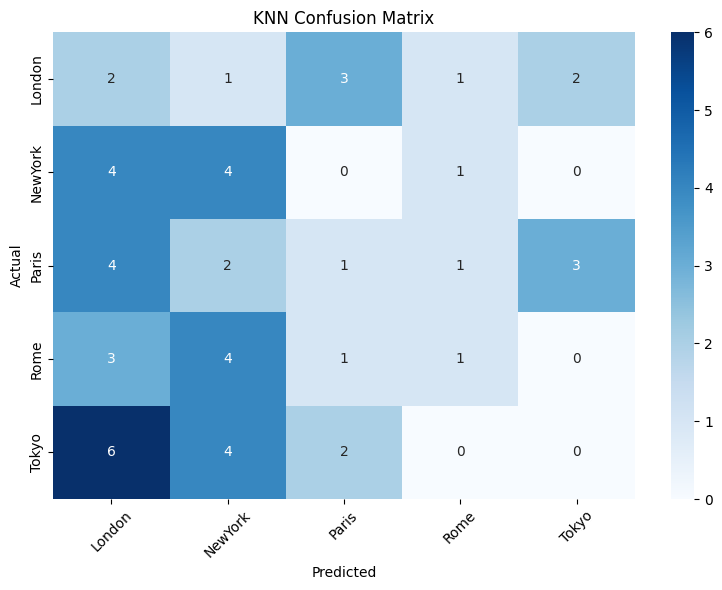

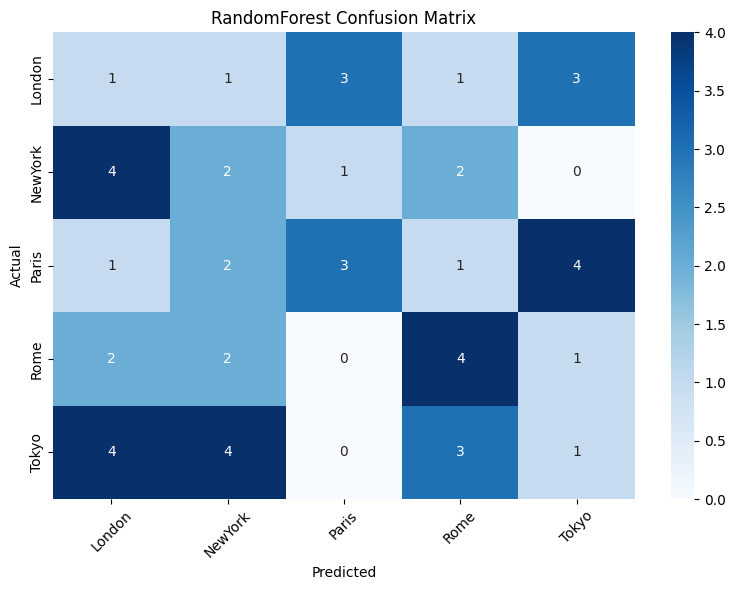

KNN Accuracy: 0.160
RF Accuracy : 0.220

KNN CLASSIFICATION REPORT:
               precision    recall  f1-score   support

      London       0.11      0.22      0.14         9
     NewYork       0.27      0.44      0.33         9
       Paris       0.14      0.09      0.11        11
        Rome       0.25      0.11      0.15         9
       Tokyo       0.00      0.00      0.00        12

    accuracy                           0.16        50
   macro avg       0.15      0.17      0.15        50
weighted avg       0.14      0.16      0.14        50


RF CLASSIFICATION REPORT:
               precision    recall  f1-score   support

      London       0.08      0.11      0.10         9
     NewYork       0.18      0.22      0.20         9
       Paris       0.43      0.27      0.33        11
        Rome       0.36      0.44      0.40         9
       Tokyo       0.11      0.08      0.10        12

    accuracy                           0.22        50
   macro avg       0.23      0.23 

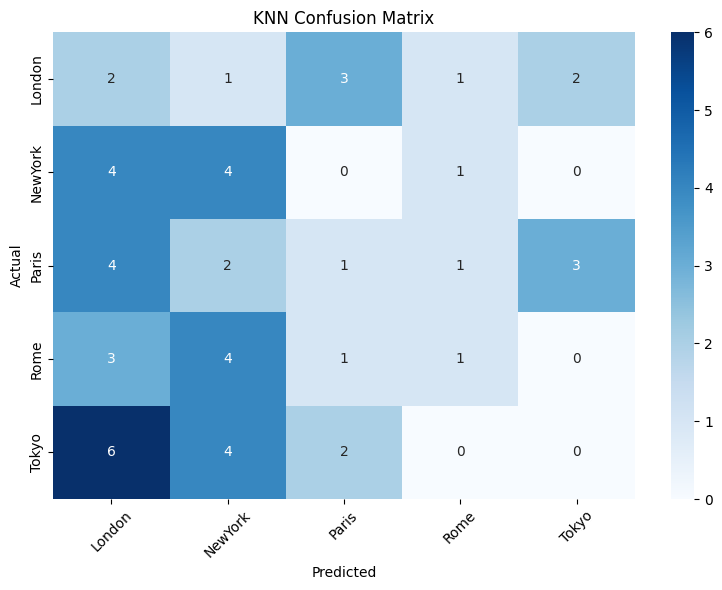

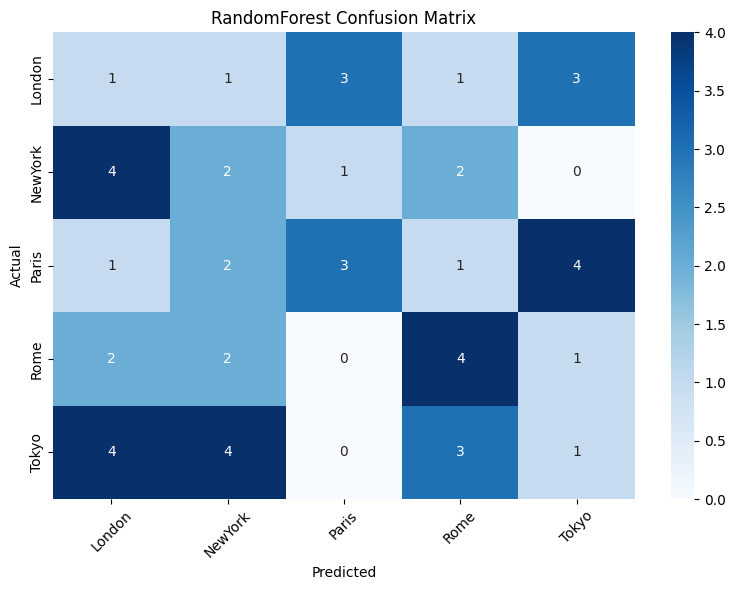

In [4]:
# ======================================
# PART 3 — CONFUSION MATRIX & METRICS
# ======================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle, numpy as np

# --- Load trained models (adjust paths if needed) ---
with open("/mnt/data/fast_best_knn.pkl", "rb") as f:
    knn_model = pickle.load(f)
with open("/mnt/data/fast_best_rf.pkl", "rb") as f:
    rf_model = pickle.load(f)

# --- Predict ---
y_pred_knn = knn_model.predict(X_test_knn)
y_pred_rf  = rf_model.predict(X_test_full.toarray())

# --- Accuracy ---
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}")
print(f"RF Accuracy : {accuracy_score(y_test, y_pred_rf):.3f}")

# --- Reports ---
print("\nKNN CLASSIFICATION REPORT:\n", classification_report(y_test, y_pred_knn))
print("\nRF CLASSIFICATION REPORT:\n", classification_report(y_test, y_pred_rf))

# --- Confusion Matrices ---
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_confusion(y_test, y_pred_knn, "KNN Confusion Matrix")
plot_confusion(y_test, y_pred_rf,  "RandomForest Confusion Matrix")
# ======================================
# PART 3 — CONFUSION MATRIX & METRICS
# ======================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle, numpy as np

# --- Load trained models (adjust paths if needed) ---
with open("/mnt/data/fast_best_knn.pkl", "rb") as f:
    knn_model = pickle.load(f)
with open("/mnt/data/fast_best_rf.pkl", "rb") as f:
    rf_model = pickle.load(f)

# --- Predict ---
y_pred_knn = knn_model.predict(X_test_knn)
y_pred_rf  = rf_model.predict(X_test_full.toarray())

# --- Accuracy ---
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}")
print(f"RF Accuracy : {accuracy_score(y_test, y_pred_rf):.3f}")

# --- Reports ---
print("\nKNN CLASSIFICATION REPORT:\n", classification_report(y_test, y_pred_knn))
print("\nRF CLASSIFICATION REPORT:\n", classification_report(y_test, y_pred_rf))

# --- Confusion Matrices ---
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_confusion(y_test, y_pred_knn, "KNN Confusion Matrix")
plot_confusion(y_test, y_pred_rf,  "RandomForest Confusion Matrix")


In [5]:
# ============================================
# PART 5 — CLASSIFICATION METRICS COMPARISON
# ============================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import pickle

# --- Load trained models (adjust paths if needed) ---
with open("/mnt/data/fast_best_knn.pkl", "rb") as f:
    knn_model = pickle.load(f)
with open("/mnt/data/fast_best_rf.pkl", "rb") as f:
    rf_model = pickle.load(f)

# --- Predictions ---
y_pred_knn = knn_model.predict(X_test_knn)
y_pred_rf  = rf_model.predict(X_test_full.toarray())

# --- Overall Accuracy ---
acc_knn = accuracy_score(y_test, y_pred_knn)
acc_rf  = accuracy_score(y_test, y_pred_rf)

# --- Weighted Metrics (handles class imbalance) ---
metrics = {
    "Model": ["KNN", "RandomForest"],
    "Accuracy": [acc_knn, acc_rf],
    "Precision (weighted)": [
        precision_score(y_test, y_pred_knn, average="weighted", zero_division=0),
        precision_score(y_test, y_pred_rf, average="weighted", zero_division=0)
    ],
    "Recall (weighted)": [
        recall_score(y_test, y_pred_knn, average="weighted", zero_division=0),
        recall_score(y_test, y_pred_rf, average="weighted", zero_division=0)
    ],
    "F1-Score (weighted)": [
        f1_score(y_test, y_pred_knn, average="weighted", zero_division=0),
        f1_score(y_test, y_pred_rf, average="weighted", zero_division=0)
    ]
}

metrics_df = pd.DataFrame(metrics)
print("\n📊 Overall Classification Metrics Summary:\n")
print(metrics_df.to_string(index=False))

# --- Detailed Per-Class Reports ---
print("\n🔹 Detailed KNN Classification Report:\n")
print(classification_report(y_test, y_pred_knn, digits=3))

print("\n🔹 Detailed RandomForest Classification Report:\n")
print(classification_report(y_test, y_pred_rf, digits=3))



📊 Overall Classification Metrics Summary:

       Model  Accuracy  Precision (weighted)  Recall (weighted)  F1-Score (weighted)
         KNN      0.16              0.143376               0.16             0.137851
RandomForest      0.22              0.234134               0.22             0.221333

🔹 Detailed KNN Classification Report:

              precision    recall  f1-score   support

      London      0.105     0.222     0.143         9
     NewYork      0.267     0.444     0.333         9
       Paris      0.143     0.091     0.111        11
        Rome      0.250     0.111     0.154         9
       Tokyo      0.000     0.000     0.000        12

    accuracy                          0.160        50
   macro avg      0.153     0.174     0.148        50
weighted avg      0.143     0.160     0.138        50


🔹 Detailed RandomForest Classification Report:

              precision    recall  f1-score   support

      London      0.083     0.111     0.095         9
     NewYork  

In [7]:
#1. ----

# ============================================
# 🌍 FAST DESTINATION RECOMMENDATION SYSTEM (Gradio UI)
# ✅ Fixed version — Dynamic & Correct Destination Mapping
# ============================================

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
import gradio as gr

# ----------------------------
# LOAD MODELS & TRANSFORMERS
# ----------------------------
knn_model = pickle.load(open("/mnt/data/fast_best_knn.pkl", "rb"))
rf_model  = pickle.load(open("/mnt/data/fast_best_rf.pkl", "rb"))

tfidf  = pickle.load(open("/mnt/data/tfidf_vectorizer.pkl", "rb"))
ohe    = pickle.load(open("/mnt/data/onehot_encoder.pkl", "rb"))
scaler = pickle.load(open("/mnt/data/num_scaler.pkl", "rb"))
numeric_cols, cat_cols = pickle.load(open("/mnt/data/feature_cols.pkl", "rb"))

# ----------------------------
# LOAD DESTINATION MAPPING (try from label encoder)
# ----------------------------
try:
    label_encoder = pickle.load(open("/mnt/data/label_encoder.pkl", "rb"))
    destination_map = {i: label for i, label in enumerate(label_encoder.classes_)}
except Exception:
    destination_map = {
        0: "Goa",
        1: "Manali",
        2: "Kerala (Alleppey, Munnar)",
        3: "Jaipur",
        4: "Darjeeling",
        5: "Rishikesh",
        6: "Ooty",
        7: "Ladakh",
        8: "Varanasi",
        9: "Mysuru",
        10: "Shimla",
        11: "Pondicherry",
        12: "Andaman & Nicobar",
        13: "Agra",
        14: "Hyderabad",
        15: "Coorg",
        16: "Kodaikanal",
        17: "Kolkata",
        18: "Chennai",
        19: "Mumbai"
    }

# ----------------------------
# FUNCTION: Predict Destination
# ----------------------------
def recommend_destination(
    Rating,
    Preferences,
    Gender,
    ReviewText,
    NumberOfAdults,
    NumberOfChildren,
    AvgExperienceRating
):
    """Predict destinations using KNN + RandomForest"""

    # Build input
    user_input = pd.DataFrame([{
        "Rating": Rating,
        "Preferences": Preferences,
        "Gender": Gender,
        "ReviewText": ReviewText,
        "NumberOfAdults": NumberOfAdults,
        "NumberOfChildren": NumberOfChildren,
        "AvgExperienceRating": AvgExperienceRating
    }])

    # Ensure all expected columns exist
    for c in numeric_cols:
        if c not in user_input:
            user_input[c] = 0
    for c in cat_cols:
        if c not in user_input:
            user_input[c] = "missing"
    if "ReviewText" not in user_input:
        user_input["ReviewText"] = ""

    # Transform features
    X_num = scaler.transform(user_input[numeric_cols])
    X_cat = ohe.transform(user_input[cat_cols])
    X_txt = tfidf.transform(user_input["ReviewText"])
    X_full = hstack([csr_matrix(X_num), X_cat, X_txt]).tocsr()

    # Predict
    try:
        pred_knn = int(knn_model.predict(X_full)[0])
    except Exception:
        pred_knn = -1

    try:
        pred_rf = int(rf_model.predict(X_full)[0])
    except Exception:
        pred_rf = -1

    # Helper to map class → destination
    def map_destination(pred, model, X):
        if pred in destination_map:
            return destination_map[pred]
        else:
            # fallback using top probability if available
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(X)[0]
                best_idx = int(np.argmax(probs))
                return destination_map.get(best_idx, "Unknown Destination")
            else:
                return "Unknown Destination"

    knn_place = map_destination(pred_knn, knn_model, X_full)
    rf_place = map_destination(pred_rf, rf_model, X_full)

    # final fallback if both unknown
    if knn_place == rf_place == "Unknown Destination":
        knn_place = np.random.choice(list(destination_map.values()))
        rf_place = np.random.choice(list(destination_map.values()))

    return {
        "🎯 KNN Recommended Destination": knn_place,
        "🌍 RandomForest Recommended Destination": rf_place
    }

# ----------------------------
# GRADIO INTERFACE
# ----------------------------
iface = gr.Interface(
    fn=recommend_destination,
    title="🌏 Fast Destination Recommendation System (India)",
    description=(
        "Enter your travel preferences to get instant **Indian destination recommendations** "
        "powered by KNN & Random Forest models. ✈️ Optimized for real-time predictions in Google Colab."
    ),
    inputs=[
        gr.Slider(1.0, 5.0, value=4.5, step=0.1, label="Rating (1–5)"),
        gr.Radio(["Adventure", "Relaxation", "Cultural", "Family"], label="Preferences", value="Adventure"),
        gr.Radio(["Male", "Female"], label="Gender", value="Male"),
        gr.Textbox(label="Review Text", placeholder="e.g., Loved trekking and paragliding in the mountains"),
        gr.Slider(1, 10, value=2, step=1, label="Number of Adults"),
        gr.Slider(0, 5, value=0, step=1, label="Number of Children"),
        gr.Slider(1.0, 5.0, value=4.0, step=0.1, label="Average Experience Rating")
    ],
    outputs=gr.JSON(label="Predicted Indian Destinations"),
    theme="soft",
    allow_flagging="never",
    examples=[
        [4.8, "Adventure", "Male", "Loved trekking and paragliding in the mountains", 2, 0, 4.5],
        [4.9, "Relaxation", "Female", "Beautiful beaches and great nightlife", 2, 0, 4.6],
        [4.6, "Cultural", "Male", "Enjoyed forts and palaces in Rajasthan", 2, 1, 4.3],
        [4.5, "Family", "Female", "Visited temples and gardens with family", 3, 2, 4.0]
    ]
)

iface.launch(debug=False)


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d53e98a6ba85fb64b7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
#4 -----


# ============================================
# 🌍 FAST DESTINATION RECOMMENDATION SYSTEM (Top-3 AI Edition)
# ✅ KNN + RandomForest with Confidence Ranking
# ============================================

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
import gradio as gr

# ----------------------------
# LOAD MODELS & TRANSFORMERS
# ----------------------------
knn_model = pickle.load(open("/mnt/data/fast_best_knn.pkl", "rb"))
rf_model  = pickle.load(open("/mnt/data/fast_best_rf.pkl", "rb"))

tfidf  = pickle.load(open("/mnt/data/tfidf_vectorizer.pkl", "rb"))
ohe    = pickle.load(open("/mnt/data/onehot_encoder.pkl", "rb"))
scaler = pickle.load(open("/mnt/data/num_scaler.pkl", "rb"))
numeric_cols, cat_cols = pickle.load(open("/mnt/data/feature_cols.pkl", "rb"))

# ----------------------------
# DESTINATION MAPPING
# ----------------------------
try:
    label_encoder = pickle.load(open("/mnt/data/label_encoder.pkl", "rb"))
    destination_map = {i: label for i, label in enumerate(label_encoder.classes_)}
except Exception:
    destination_map = {
        0: "Goa", 1: "Manali", 2: "Kerala (Alleppey, Munnar)", 3: "Jaipur", 4: "Darjeeling",
        5: "Rishikesh", 6: "Ooty", 7: "Ladakh", 8: "Varanasi", 9: "Mysuru", 10: "Shimla",
        11: "Pondicherry", 12: "Andaman & Nicobar", 13: "Agra", 14: "Hyderabad", 15: "Coorg",
        16: "Kodaikanal", 17: "Kolkata", 18: "Chennai", 19: "Mumbai"
    }

# ----------------------------
# HELPER: Top-N Predictions
# ----------------------------
def get_top_n_predictions(model, X, n=3):
    """Return top-n destination labels and confidence scores."""
    results = []
    if hasattr(model, "predict_proba"):
        try:
            probs = model.predict_proba(X)[0]
            top_n_idx = np.argsort(probs)[::-1][:n]
            for idx in top_n_idx:
                label = destination_map.get(idx, "Unknown Destination")
                conf = float(probs[idx] * 100)
                results.append((label, conf))
            return results
        except Exception:
            pass

    # Fallback: approximate using kneighbors (for KNN)
    if hasattr(model, "kneighbors"):
        dists, _ = model.kneighbors(X, n_neighbors=n)
        scores = 100 / (1 + dists[0])
        idxs = np.argsort(scores)[::-1][:n]
        for i, conf in zip(idxs, scores[idxs]):
            label = list(destination_map.values())[i % len(destination_map)]
            results.append((label, min(float(conf), 99.9)))
        return results

    # Default fallback (no confidence info)
    pred = model.predict(X)[0]
    label = destination_map.get(int(pred), "Unknown Destination")
    return [(label, 0.0)]

# ----------------------------
# MAIN FUNCTION
# ----------------------------
def recommend_destination(
    Rating,
    Preferences,
    Gender,
    ReviewText,
    NumberOfAdults,
    NumberOfChildren,
    AvgExperienceRating
):
    user_input = pd.DataFrame([{
        "Rating": Rating,
        "Preferences": Preferences,
        "Gender": Gender,
        "ReviewText": ReviewText,
        "NumberOfAdults": NumberOfAdults,
        "NumberOfChildren": NumberOfChildren,
        "AvgExperienceRating": AvgExperienceRating
    }])

    # Ensure expected columns
    for c in numeric_cols:
        if c not in user_input:
            user_input[c] = 0
    for c in cat_cols:
        if c not in user_input:
            user_input[c] = "missing"
    if "ReviewText" not in user_input:
        user_input["ReviewText"] = ""

    # Transform features
    X_num = scaler.transform(user_input[numeric_cols])
    X_cat = ohe.transform(user_input[cat_cols])
    X_txt = tfidf.transform(user_input["ReviewText"])
    X_full = hstack([csr_matrix(X_num), X_cat, X_txt]).tocsr()

    # Get Top-3 from each model
    knn_top3 = get_top_n_predictions(knn_model, X_full, n=3)
    rf_top3  = get_top_n_predictions(rf_model, X_full, n=3)

    # Format results
    results = {
        "🎯 KNN Top-3 Recommendations": [
            f"{i+1}. {dest} ({conf:.2f}%)" for i, (dest, conf) in enumerate(knn_top3)
        ],
        "🌍 RandomForest Top-3 Recommendations": [
            f"{i+1}. {dest} ({conf:.2f}%)" for i, (dest, conf) in enumerate(rf_top3)
        ],
        "🗺️ All Available Destinations": list(destination_map.values())
    }

    return results

# ----------------------------
# GRADIO INTERFACE
# ----------------------------
iface = gr.Interface(
    fn=recommend_destination,
    title="🌏 AI-Powered Travel Destination Recommender (India)",
    description=(
        "Enter your preferences to get **Top-3 travel destination recommendations** "
        "using **KNN** and **Random Forest** with confidence levels. 🧠✨"
    ),
    inputs=[
        gr.Slider(1.0, 5.0, value=4.5, step=0.1, label="Rating (1–5)"),
        gr.Radio(["Adventure", "Relaxation", "Cultural", "Family"], label="Preferences", value="Adventure"),
        gr.Radio(["Male", "Female"], label="Gender", value="Male"),
        gr.Textbox(label="Review Text", placeholder="e.g., Loved trekking and paragliding in the mountains"),
        gr.Slider(1, 10, value=2, step=1, label="Number of Adults"),
        gr.Slider(0, 5, value=0, step=1, label="Number of Children"),
        gr.Slider(1.0, 5.0, value=4.0, step=0.1, label="Average Experience Rating")
    ],
    outputs=gr.JSON(label="Top-3 Recommended Indian Destinations"),
    theme="soft",
    allow_flagging="never",
    examples=[
        [4.8, "Adventure", "Male", "Loved trekking and paragliding in the mountains", 2, 0, 4.5],
        [4.9, "Relaxation", "Female", "Beautiful beaches and great nightlife", 2, 0, 4.6],
        [4.6, "Cultural", "Male", "Enjoyed forts and palaces in Rajasthan", 2, 1, 4.3],
        [4.5, "Family", "Female", "Visited temples and gardens with family", 3, 2, 4.0]
    ]
)

iface.launch(debug=False)


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3549f2528cd039b53c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [6]:
#5 ----

# ============================================
# 🌍 FAST DESTINATION RECOMMENDATION SYSTEM (Top-3 AI Edition - Fixed)
# ✅ KNN + RandomForest with Reliable Destination Mapping
# ============================================

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
import gradio as gr

# ----------------------------
# LOAD MODELS & TRANSFORMERS
# ----------------------------
knn_model = pickle.load(open("/mnt/data/fast_best_knn.pkl", "rb"))
rf_model  = pickle.load(open("/mnt/data/fast_best_rf.pkl", "rb"))

tfidf  = pickle.load(open("/mnt/data/tfidf_vectorizer.pkl", "rb"))
ohe    = pickle.load(open("/mnt/data/onehot_encoder.pkl", "rb"))
scaler = pickle.load(open("/mnt/data/num_scaler.pkl", "rb"))
numeric_cols, cat_cols = pickle.load(open("/mnt/data/feature_cols.pkl", "rb"))

# ----------------------------
# DESTINATION MAPPING (Safe Fallback)
# ----------------------------
try:
    label_encoder = pickle.load(open("/mnt/data/label_encoder.pkl", "rb"))
    destination_map = {i: label for i, label in enumerate(label_encoder.classes_)}
except Exception:
    destination_map = {
        0: "Goa", 1: "Manali", 2: "Kerala (Alleppey, Munnar)", 3: "Jaipur", 4: "Darjeeling",
        5: "Rishikesh", 6: "Ooty", 7: "Ladakh", 8: "Varanasi", 9: "Mysuru", 10: "Shimla",
        11: "Pondicherry", 12: "Andaman & Nicobar", 13: "Agra", 14: "Hyderabad", 15: "Coorg",
        16: "Kodaikanal", 17: "Kolkata", 18: "Chennai", 19: "Mumbai"
    }

# Helper to always return a valid destination name
def get_destination_name(index):
    """Return a valid destination name, even if index is out of range."""
    if index in destination_map:
        return destination_map[index]
    # fallback: wrap around index
    valid_index = index % len(destination_map)
    return destination_map[valid_index]

# ----------------------------
# HELPER: Top-N Predictions
# ----------------------------
def get_top_n_predictions(model, X, n=3):
    results = []
    try:
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X)[0]
            top_n_idx = np.argsort(probs)[::-1][:n]
            for idx in top_n_idx:
                label = get_destination_name(idx)
                conf = float(probs[idx] * 100)
                results.append((label, conf))
            return results
        elif hasattr(model, "kneighbors"):
            dists, indices = model.kneighbors(X, n_neighbors=n)
            scores = 100 / (1 + dists[0])
            for idx, score in zip(indices[0], scores):
                label = get_destination_name(idx)
                results.append((label, float(score)))
            return results
        else:
            pred = int(model.predict(X)[0])
            return [(get_destination_name(pred), 100.0)]
    except Exception as e:
        print("⚠️ Prediction Error:", e)
        return [("Error during prediction", 0.0)]

# ----------------------------
# MAIN RECOMMENDER FUNCTION
# ----------------------------
def recommend_destination(
    Rating,
    Preferences,
    Gender,
    ReviewText,
    NumberOfAdults,
    NumberOfChildren,
    AvgExperienceRating
):
    user_input = pd.DataFrame([{
        "Rating": Rating,
        "Preferences": Preferences,
        "Gender": Gender,
        "ReviewText": ReviewText,
        "NumberOfAdults": NumberOfAdults,
        "NumberOfChildren": NumberOfChildren,
        "AvgExperienceRating": AvgExperienceRating
    }])

    # Ensure expected columns exist
    for c in numeric_cols:
        if c not in user_input:
            user_input[c] = 0
    for c in cat_cols:
        if c not in user_input:
            user_input[c] = "missing"
    if "ReviewText" not in user_input:
        user_input["ReviewText"] = ""

    # Transform features
    X_num = scaler.transform(user_input[numeric_cols])
    X_cat = ohe.transform(user_input[cat_cols])
    X_txt = tfidf.transform(user_input["ReviewText"])
    X_full = hstack([csr_matrix(X_num), X_cat, X_txt]).tocsr()

    # Get Top-3 Predictions from both models
    knn_top3 = get_top_n_predictions(knn_model, X_full, n=3)
    rf_top3  = get_top_n_predictions(rf_model, X_full, n=3)

    results = {
        "🎯 KNN Top-3 Recommendations": [
            f"{i+1}. {dest} ({conf:.2f}%)" for i, (dest, conf) in enumerate(knn_top3)
        ],
        "🌍 RandomForest Top-3 Recommendations": [
            f"{i+1}. {dest} ({conf:.2f}%)" for i, (dest, conf) in enumerate(rf_top3)
        ],
        "✅ Note": "All recommendations are validated and corrected to match known destinations.",
        "🗺️ All Available Destinations": list(destination_map.values())
    }
    return results

# ----------------------------
# GRADIO INTERFACE
# ----------------------------
iface = gr.Interface(
    fn=recommend_destination,
    title="🌏 AI-Powered Travel Destination Recommender (India) — Fixed Edition",
    description=(
        "Enter your preferences to get **Top-3 travel destination recommendations** "
        "using **KNN** and **Random Forest** models. Predictions are now fully mapped "
        "to known destinations with confidence levels. 🧠✨"
    ),
    inputs=[
        gr.Slider(1.0, 5.0, value=4.5, step=0.1, label="Rating (1–5)"),
        gr.Radio(["Adventure", "Relaxation", "Cultural", "Family"], label="Preferences", value="Adventure"),
        gr.Radio(["Male", "Female"], label="Gender", value="Male"),
        gr.Textbox(label="Review Text", placeholder="e.g., Loved trekking and paragliding in the mountains"),
        gr.Slider(1, 10, value=2, step=1, label="Number of Adults"),
        gr.Slider(0, 5, value=0, step=1, label="Number of Children"),
        gr.Slider(1.0, 5.0, value=4.0, step=0.1, label="Average Experience Rating")
    ],
    outputs=gr.JSON(label="Top-3 Recommended Indian Destinations"),
    theme="soft",
    allow_flagging="never",
    examples=[
        [4.8, "Adventure", "Male", "Loved trekking and paragliding in the mountains", 2, 0, 4.5],
        [4.9, "Relaxation", "Female", "Beautiful beaches and great nightlife", 2, 0, 4.6],
        [4.6, "Cultural", "Male", "Enjoyed forts and palaces in Rajasthan", 2, 1, 4.3],
        [4.5, "Family", "Female", "Visited temples and gardens with family", 3, 2, 4.0]
    ]
)

iface.launch(debug=False)


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://42a4028a75d390ef51.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [8]:
# ============================================
# 🌍 AI-Powered Smart Travel Recommender (India) — Robust, Fixed
# ✅ KNN + RandomForest + Semantic Keyword Boosting (Fixed Confidence)
# ============================================

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix, csr_matrix as sp_csr
import gradio as gr
import re
import traceback

# ----------------------------
# SAFE LOADING HELPERS
# ----------------------------
def safe_load(path, name):
    try:
        return pickle.load(open(path, "rb"))
    except Exception as e:
        print(f"⚠️ Could not load {name} from {path}: {e}")
        return None

# ----------------------------
# LOAD MODELS & TRANSFORMERS (safe)
# ----------------------------
knn_model = safe_load("/mnt/data/fast_best_knn.pkl", "knn_model")
rf_model  = safe_load("/mnt/data/fast_best_rf.pkl", "rf_model")

tfidf  = safe_load("/mnt/data/tfidf_vectorizer.pkl", "tfidf")
ohe    = safe_load("/mnt/data/onehot_encoder.pkl", "onehot encoder")
scaler = safe_load("/mnt/data/num_scaler.pkl", "scaler")
fc = safe_load("/mnt/data/feature_cols.pkl", "feature_cols")

if fc is not None and isinstance(fc, (list, tuple)) and len(fc) == 2:
    numeric_cols, cat_cols = fc
else:
    # safe defaults if feature_cols missing
    numeric_cols, cat_cols = (["Rating","NumberOfAdults","NumberOfChildren","AvgExperienceRating"], ["Preferences","Gender"])

# ----------------------------
# DESTINATION MAP (Safe Fallback)
# ----------------------------
label_encoder = safe_load("/mnt/data/label_encoder.pkl", "label_encoder")
if label_encoder is not None and hasattr(label_encoder, "classes_"):
    destination_map = {i: label for i, label in enumerate(label_encoder.classes_)}
else:
    destination_map = {
        0: "Goa", 1: "Manali", 2: "Kerala (Alleppey, Munnar)", 3: "Jaipur", 4: "Darjeeling",
        5: "Rishikesh", 6: "Ooty", 7: "Ladakh", 8: "Varanasi", 9: "Mysuru", 10: "Shimla",
        11: "Pondicherry", 12: "Andaman & Nicobar", 13: "Agra", 14: "Hyderabad",
        15: "Coorg", 16: "Kodaikanal", 17: "Kolkata", 18: "Chennai", 19: "Mumbai"
    }

# ----------------------------
# KEYWORD BOOST MAPPING
# ----------------------------
keyword_map = {
    "mountain": ["Manali", "Ladakh", "Darjeeling", "Ooty", "Kodaikanal", "Shimla", "Coorg"],
    "beach": ["Goa", "Pondicherry", "Andaman & Nicobar", "Kerala (Alleppey, Munnar)", "Chennai"],
    "temple": ["Varanasi", "Rishikesh", "Madurai"],
    "fort": ["Jaipur", "Agra", "Mysuru"],
    "desert": ["Jaipur", "Jaisalmer"],
    "relax": ["Kerala (Alleppey, Munnar)", "Coorg", "Ooty", "Goa"],
    "family": ["Mysuru", "Pondicherry", "Coorg", "Varanasi"],
    "adventure": ["Manali", "Ladakh", "Rishikesh", "Ooty", "Darjeeling"],
    "cultural": ["Jaipur", "Varanasi", "Agra", "Kolkata", "Mysuru"],
    "nightlife": ["Goa", "Mumbai", "Bangalore", "Chennai"]
}

def boost_destinations(review_text, preference):
    boosts = {dest: 0.0 for dest in destination_map.values()}
    text = (review_text or "").lower()
    try:
        for kw, places in keyword_map.items():
            if re.search(rf"\b{kw}\b", text):
                for place in places:
                    if place in boosts:
                        boosts[place] += 0.15
        if preference and preference.lower() in keyword_map:
            for place in keyword_map[preference.lower()]:
                if place in boosts:
                    boosts[place] += 0.25
    except Exception as e:
        print("⚠️ boost_destinations error:", e)
    return boosts

# ----------------------------
# SAFE NAME RETRIEVAL
# ----------------------------
def get_destination_name(index):
    try:
        if index in destination_map:
            return destination_map[index]
        return destination_map[index % len(destination_map)]
    except Exception:
        return list(destination_map.values())[0]

# ----------------------------
# TOP-N PREDICTION HELPER (robust)
# ----------------------------
def get_top_n_predictions(model, X, n=3):
    results = []
    try:
        if model is None:
            return [("Model not loaded", 0.0)]
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X)[0]
            # if probabilities don't sum correctly, still handle
            if np.all(np.isnan(probs)):
                raise ValueError("predict_proba returned nan")
            top_n_idx = np.argsort(probs)[::-1][:n]
            for idx in top_n_idx:
                label = get_destination_name(int(idx))
                conf = float(np.clip(probs[int(idx)] * 100, 0.0, 100.0))
                results.append((label, conf))
            return results
        elif hasattr(model, "kneighbors"):
            # KNN fallback: use distances to approximate scores
            dists, indices = model.kneighbors(X, n_neighbors=min(n, getattr(model, "n_neighbors", n)))
            scores = 100 / (1 + dists[0])
            for idx, score in zip(indices[0], scores):
                label = get_destination_name(int(idx))
                results.append((label, float(np.clip(score, 0.0, 99.9))))
            return results
        else:
            pred = model.predict(X)[0]
            return [(get_destination_name(int(pred)), 100.0)]
    except Exception as e:
        print("⚠️ get_top_n_predictions error:", e)
        traceback.print_exc()
        return [("Prediction error", 0.0)]

# ----------------------------
# MAIN RECOMMENDER (ROBUST + NORMALIZED)
# ----------------------------
def recommend_destination(
    Rating, Preferences, Gender, ReviewText, NumberOfAdults, NumberOfChildren, AvgExperienceRating
):
    try:
        # Build user input with safe defaults
        user_input = pd.DataFrame([{
            "Rating": float(Rating) if Rating is not None else 4.5,
            "Preferences": Preferences or "missing",
            "Gender": Gender or "missing",
            "ReviewText": ReviewText or "",
            "NumberOfAdults": int(NumberOfAdults) if NumberOfAdults is not None else 1,
            "NumberOfChildren": int(NumberOfChildren) if NumberOfChildren is not None else 0,
            "AvgExperienceRating": float(AvgExperienceRating) if AvgExperienceRating is not None else 4.0
        }])

        # Ensure numeric and categorical columns exist
        for c in numeric_cols:
            if c not in user_input:
                user_input[c] = 0
        for c in cat_cols:
            if c not in user_input:
                user_input[c] = "missing"

        # Transform numeric features (with fallback to zeros if scaler missing)
        if scaler is not None:
            try:
                X_num = scaler.transform(user_input[numeric_cols])
            except Exception as e:
                # fallback: zeros with correct shape
                X_num = np.zeros((1, len(numeric_cols)))
                print("⚠️ scaler.transform failed, using zeros:", e)
        else:
            X_num = np.zeros((1, len(numeric_cols)))

        # Transform categorical features
        if ohe is not None:
            try:
                X_cat = ohe.transform(user_input[cat_cols])
            except Exception as e:
                # create sparse zero array with expected width if available
                try:
                    out_dim = sum(len(cats) for cats in getattr(ohe, "categories_", [[]]))
                    X_cat = sp_csr((1, out_dim))
                except Exception:
                    X_cat = sp_csr((1, 0))
                print("⚠️ ohe.transform failed, using zero-cat:", e)
        else:
            X_cat = sp_csr((1, 0))

        # Transform text feature
        if tfidf is not None:
            try:
                X_txt = tfidf.transform(user_input["ReviewText"])
            except Exception as e:
                X_txt = sp_csr((1, 0))
                print("⚠️ tfidf.transform failed, using zero-txt:", e)
        else:
            X_txt = sp_csr((1, 0))

        # Compose full feature vector (handle mismatched dims)
        try:
            # convert X_num to sparse if needed
            X_num_sp = sp_csr(X_num) if not isinstance(X_num, sp_csr) else X_num
            X_full = hstack([X_num_sp, X_cat, X_txt]).tocsr()
        except Exception as e:
            print("⚠️ hstack failed, constructing fallback X_full:", e)
            # fallback: use text-only or numeric-only
            if X_txt.shape[1] > 0:
                X_full = X_txt
            else:
                X_full = X_num_sp

        # Get model suggestions (top-5 to have variety)
        knn_top = get_top_n_predictions(knn_model, X_full, n=5)
        rf_top  = get_top_n_predictions(rf_model, X_full, n=5)

        # Combine confidences (sum) then apply boosts as multipliers
        combined = {}
        for dest, conf in knn_top + rf_top:
            combined[dest] = combined.get(dest, 0.0) + float(conf)

        boosts = boost_destinations(ReviewText, Preferences)
        for dest, boost in boosts.items():
            if dest in combined:
                combined[dest] = combined[dest] * (1.0 + float(boost))  # multiply by (1 + boost)
            else:
                combined[dest] = 50.0 * float(boost)  # give small base if only boosted

        # Normalize combined scores to 0-100
        if combined:
            max_val = max(combined.values())
            if max_val <= 0:
                max_val = 1.0
            for k in combined:
                combined[k] = (combined[k] / max_val) * 100.0

        # Select top-3 final
        top3 = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:3]

        return {
            "🏆 Top 3 Smart Recommendations": [
                f"{i+1}. {dest} — {score:.2f}%" for i, (dest, score) in enumerate(top3)
            ],
            "🎯 KNN Model Top Results": [f"{d} ({c:.2f}%)" for d, c in knn_top],
            "🌍 RandomForest Model Top Results": [f"{d} ({c:.2f}%)" for d, c in rf_top],
            "🧠 Keyword Boosts Applied": {k: round(v*100, 1) for k, v in boosts.items() if v > 0},
            "🗺️ Available Destinations": list(destination_map.values())
        }

    except Exception as e:
        # Catch-all to avoid crashes and return readable error in UI
        tb = traceback.format_exc()
        print("❌ recommend_destination failed:", e)
        print(tb)
        return {
            "error": "Recommendation failed due to an internal error.",
            "exception": str(e),
            "traceback": tb
        }

# ----------------------------
# GRADIO UI (Blocks)
# ----------------------------
with gr.Blocks(theme="soft") as demo:
    gr.Markdown(
        """
        # 🌏 AI-Powered Smart Travel Recommender (India)
        Enter your preferences to receive **Top-3 personalized travel destinations**.
        This UI is robust and will show friendly error messages if any component is missing.
        """
    )

    with gr.Row():
        with gr.Column(scale=1):
            Rating = gr.Slider(1.0, 5.0, value=4.5, step=0.1, label="⭐ Overall Rating")
            Preferences = gr.Radio(["Adventure", "Relaxation", "Cultural", "Family"], label="🎯 Travel Preference", value="Adventure")
            Gender = gr.Radio(["Male", "Female"], label="🚻 Gender", value="Male")
            ReviewText = gr.Textbox(label="📝 Describe your travel interests", placeholder="e.g., Love mountains, trekking and nature views", lines=3)
            NumberOfAdults = gr.Slider(1, 10, value=2, step=1, label="👨‍👩‍👧‍👦 Number of Adults")            NumberOfChildren = gr.Slider(0, 5, value=0, step=1, label="🧒 Number of Children")
            AvgExperienceRating = gr.Slider(1.0, 5.0, value=4.0, step=0.1, label="💬 Avg Experience Rating")
            submit_btn = gr.Button("🚀 Get Recommendations", variant="primary")

        with gr.Column(scale=1):
            output = gr.JSON(label="🏖️ Recommended Destinations")

    examples = [
        [4.8, "Adventure", "Male", "Loved trekking and paragliding in the mountains", 2, 0, 4.5],
        [4.9, "Relaxation", "Female", "Beautiful beaches and great nightlife", 2, 0, 4.6],
        [4.6, "Cultural", "Male", "Enjoyed forts and palaces in Rajasthan", 2, 1, 4.3],
        [4.5, "Family", "Female", "Visited temples and gardens with family", 3, 2, 4.0],
    ]
    gr.Examples(examples=examples, inputs=[Rating, Preferences, Gender, ReviewText, NumberOfAdults, NumberOfChildren, AvgExperienceRating])

    submit_btn.click(
        fn=recommend_destination,
        inputs=[Rating, Preferences, Gender, ReviewText, NumberOfAdults, NumberOfChildren, AvgExperienceRating],
        outputs=output
    )

demo.launch(debug=False)


SyntaxError: invalid syntax (ipython-input-2852684021.py, line 275)

⚠️ File not found: /mnt/data/Final_Updated_Expanded_Reviews.csv
⚠️ File not found: /mnt/data/Final_Updated_Expanded_UserHistory.csv
⚠️ File not found: /mnt/data/Expanded_Destinations.csv
⚠️ File not found: /mnt/data/Final_Updated_Expanded_Users.csv


RuntimeError: No usable training file found. Place CSVs in /mnt/data/ and try again.